# 重新读入数据，使用GBDT+LR

In [1]:
import numpy as np
import pandas as pd
import scipy as sc
import scipy.sparse as sp
from sklearn.utils import check_random_state 
import pylab 
import sys
import time
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
fea0_1=pd.read_csv('~/10w_train_count_day_hash.csv')
fea1_1=pd.read_csv('~/test_count_day_hash.csv')

# 准备数据

In [3]:
y_train = fea0_1['click']
train = fea0_1.drop([ "click","id","hour","user_count","hour_int"], axis=1)
X_test = fea1_1.drop(["id","hour","user_count","hour_int"], axis=1)
X_train = train

In [4]:
train.columns

Index(['C1', 'banner_pos', 'site_id', 'site_domain', 'site_category', 'app_id',
       'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model',
       'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18',
       'C19', 'C20', 'C21', 'device_id_count', 'device_ip_count', 'day_week',
       'hour_day', 'is_weekend'],
      dtype='object')

catNum=['site_id','site_domain','site_category','app_id','app_domain',
        'app_category','device_id','device_ip','device_model','C17','C19',
        'C20','C21','hour_day','device_id_count','device_ip_count','user_count']

In [5]:
features_one=['C1','banner_pos','device_type','device_conn_type','C15','C16','C18','day_week','is_weekend']
X_train_one=X_train[features_one]
X_test_one=X_test[features_one]
X_train_two=X_train.drop(features_one,axis=1)
X_test_two=X_test.drop(features_one,axis=1)

In [6]:
(train_rows_1, cols_1) = X_train_one.shape
X_data_one = pd.concat([X_train_one, X_test_one], axis = 0, ignore_index=False)

In [7]:
from sklearn.preprocessing import OneHotEncoder
oneHot=OneHotEncoder()
X_data_one_hot=oneHot.fit_transform(X_data_one)

In [8]:
X_data_one_hot=X_data_one

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from xgboost import XGBClassifier
import xgboost as xgb

In [10]:
#先寻找最佳的树个数，n_estimators=157
#params = {"objective": "multi:softprob", "eval_metric":"mlogloss", "num_class": 9}
xgb1 = XGBClassifier(
        learning_rate =0.4,
        n_estimators=35,   #数值大没关系，使用交叉验证，cv会自动返回合适的n_estimators  
        max_depth=8,
        min_child_weight=50, # 叶子节点所需要的最小样本权重和,大小容易过拟合
        gamma=0,
        subsample = 1.0,#0.85
        colsample_bytree=0.5,
        colsample_bylevel=0.9,
        reg_alpha = 2.5,
        reg_lambda= 0.5,
        base_score=0.16,
        objective= 'binary:logistic',
        seed=999)
#'base_score':0.16, 'seed': 999  'verbose':0,
# 训练数据：X_train_part, y_train_part   验证数据：X_val, y_val
xgb1.fit(X_train_two, y_train, eval_metric='logloss')

XGBClassifier(base_score=0.16, booster='gbtree', colsample_bylevel=0.9,
       colsample_bytree=0.5, gamma=0, learning_rate=0.4, max_delta_step=0,
       max_depth=8, min_child_weight=50, missing=None, n_estimators=35,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=2.5, reg_lambda=0.5, scale_pos_weight=1, seed=999,
       silent=True, subsample=1.0)

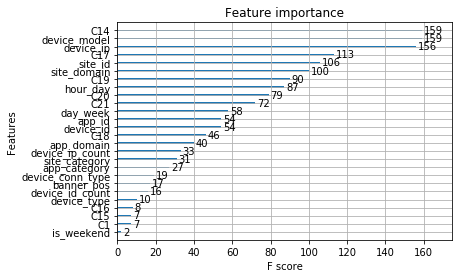

In [30]:
####xgboost进行特征重要性的选择
#可以使用XGBoost内嵌的函数，按特征重要性排序
from xgboost import plot_importance
plot_importance(xgb1)
plt.show()

In [31]:
from sklearn.model_selection import train_test_split
X_train_three, X_test_three, y_train_one, y_test_one = train_test_split(X_train,y_train,test_size=0.2,random_state=4)

In [34]:
#可以根据特征重要性进行特征选择
from numpy import sort
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
# Fit model using each importance as a threshold
thresholds = sort(xgb1.feature_importances_)
for thresh in thresholds:
  # select features using threshold
  selection = SelectFromModel(xgb1, threshold=thresh, prefit=True)
  select_X_train = selection.transform(X_train_three)
  # train model
  selection_model = XGBClassifier()
  selection_model.fit(select_X_train, y_train_one)
# eval model
  select_X_test = selection.transform(X_test_three)
  y_pred = selection_model.predict(select_X_test)
  predictions = [round(value) for value in y_pred]
  accuracy = accuracy_score(y_test_one, predictions)
  print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1],
      accuracy*100.0))

/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.001, n=26, Accuracy: 83.10%


/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.002, n=25, Accuracy: 83.10%


/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.004, n=24, Accuracy: 83.01%


/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.005, n=23, Accuracy: 82.99%


/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.005, n=23, Accuracy: 82.99%


/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.005, n=23, Accuracy: 82.99%


/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.007, n=20, Accuracy: 82.99%


/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.013, n=19, Accuracy: 82.99%


/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.019, n=18, Accuracy: 82.97%


/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.022, n=17, Accuracy: 82.98%


/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.022, n=17, Accuracy: 82.98%


/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.026, n=15, Accuracy: 82.97%


/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.027, n=14, Accuracy: 82.98%


/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.028, n=13, Accuracy: 82.97%


/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.034, n=12, Accuracy: 82.97%


/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.042, n=11, Accuracy: 82.98%


/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.043, n=10, Accuracy: 82.97%


/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.049, n=9, Accuracy: 83.00%


/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.051, n=8, Accuracy: 83.01%


/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.052, n=7, Accuracy: 82.98%


/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.069, n=6, Accuracy: 82.99%


/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.073, n=5, Accuracy: 83.04%


/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.083, n=4, Accuracy: 82.99%


/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.087, n=3, Accuracy: 82.98%


/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.102, n=2, Accuracy: 82.98%
Thresh=0.130, n=1, Accuracy: 82.98%


/home/fuxi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [12]:
xgb_train=xgb1.apply(X_train_two)

In [13]:
print(xgb_train[0])

[ 90  88  69  98  94 101  31  65  80  88 205 150  62  62  88 124  38  56
  61  89  42  80  27 136  34  67  27  91  56  39  47  52  64  81  67]


In [14]:
xgb_test =xgb1.apply(X_test_two) #学习率，太低导致不能快速收敛，肯出现memory error？？


In [15]:
(train_rows_2, cols_2) = xgb_train.shape

In [16]:
xgb_data=np.concatenate((xgb_train,xgb_test),axis=0)

In [18]:
#调用one-hot编码,对叶子结点进行编码
#使用训练好的GBDT模型构建特征，然后将特征经过one-hot编码作为新的特征输入到LR模型训练。
from sklearn.preprocessing import OneHotEncoder
oneHot = OneHotEncoder()
#使用xgb_data训练GBDT模型，后面用此模型构造特征
lr_data=oneHot.fit_transform(xgb_data)

In [19]:
lr_data=xgb_data

In [20]:
train_one_1=X_data_one_hot[:train_rows_1,:]
test_one_1=X_data_one_hot[train_rows_1:,:]

In [21]:
train_one_2=lr_data[:train_rows_2,:]
test_one_2=lr_data[train_rows_2:,:]

In [22]:
from scipy.sparse import hstack
lr_train = hstack((train_one_1,train_one_2)) 

In [23]:
'''
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
for col in X_train_one.columns:
    X_train_one[col] = labelencoder.fit_transform(X_train_one[col])
'''

In [24]:
from scipy.sparse import hstack
lr_train=hstack((X_train_one,lr_data))
lr_test =hstack((test_one_1,test_one_2))
lr_test =test_one_2

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
#需要调优的参数
# 请尝试将L1正则和L2正则分开，并配合合适的优化求解算法（slover）
tuned_parameters = {'penalty':['l1','l2'],
                   'C': [0.014, 0.012, 0.01,0.08,0.06]
                   }
lr=LogisticRegression();
#penaltys = ['l1','l2']
#s = [0.01, 0.1, 1,10,100] #使用cv时必须要有list变化的参数
#uned_parameters = dict(penalty = penaltys, C = Cs)
grid= GridSearchCV(lr, tuned_parameters,cv=5, scoring='neg_log_loss')
grid.fit(lr_train,y_train)
print(-grid.best_score_)
print(grid.best_params_)
#lr=LogisticRegression(C=11, penalty='l2',solver='liblinear')
#lr.fit(lr_train,y_train)

0.4363249939100745
{'C': 0.01, 'penalty': 'l1'}


In [29]:
train_predprob = grid.predict_proba(lr_train)
logloss = log_loss(y_train, train_predprob)
print(logloss)

0.4215660656902865


In [35]:
import pickle
pickle.dump(grid,open("lr_model.pkl",'wb'))

In [36]:
y_test_pred=grid.predict_proba(lr_test)[:,1]

In [37]:
submission=pd.read_csv('/home/fuxi/sampleSubmission')
sample_id=submission['id']

In [38]:
sub_one=pd.DataFrame(y_test_pred)
sub_one.columns=['click']

In [39]:
sub_file=pd.concat([sample_id,sub_one],axis=1)